In [204]:
import random
import datetime
import os,gc,math
import numpy as np 
import pandas as pd
import seaborn as sns
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime

### 3. Clean the data

#### 3.1 Read in data

In [88]:
building_metadata=pd.read_csv('raw_data/building_metadata.csv')
test=pd.read_csv('raw_data/test.csv')
train=pd.read_csv('raw_data/train.csv')
weather_test=pd.read_csv('raw_data/weather_test.csv')
weather_train=pd.read_csv('raw_data/weather_train.csv')
sample_submission=pd.read_csv('raw_data/sample_submission.csv')

In [89]:
# Reducing memory size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
                    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
        
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
building_metadata = reduce_mem_usage(building_metadata)
weather_test = reduce_mem_usage(weather_test)
weather_train = reduce_mem_usage(weather_train)
sample_submission = reduce_mem_usage(sample_submission)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 198.83 Mb (68.7% reduction)


#### 3.2 Remove or fill the building data with NaN

In [92]:
building_metadata.dtypes

site_id           int8
building_id      int16
primary_use     object
square_feet      int32
year_built     float16
floor_count    float16
dtype: object

In [93]:
# caculate the mean value as filling value

In [94]:
# convert inf to NaN
building_metadata=building_metadata.replace([np.inf, -np.inf], np.nan)

# floor_count
valid1 = building_metadata[pd.notnull(building_metadata['floor_count'])]
valid1[['floor_count']] = valid1[['floor_count']].astype(int)
floor_mean = round(valid1['floor_count'].mean())
print('the mean value of floor_count is',floor_mean)

# square_feet
valid2 = building_metadata[pd.notnull(building_metadata['square_feet'])]
square_mean = round(valid2['square_feet'].mean())
print('the mean value of square_feet is',square_mean)

# year_built
valid3 = building_metadata[pd.notnull(building_metadata['year_built'])]
valid3[['year_built']] = valid3[['year_built']].astype(int)
year_mean = round(valid3['year_built'].mean())
print('the mean value of year_built is',year_mean)

the mean value of floor_count is 4
the mean value of square_feet is 92112
the mean value of year_built is 1968


In [95]:
building_metadata['floor_count']=building_metadata['floor_count'].fillna(floor_mean)
building_metadata['square_feet']=building_metadata['square_feet'].fillna(square_mean)
building_metadata['year_built']=building_metadata['year_built'].fillna(year_mean)
building_metadata

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,4.0
1,0,1,Education,2720,2004.0,4.0
2,0,2,Education,5376,1991.0,4.0
3,0,3,Education,23685,2002.0,4.0
4,0,4,Education,116607,1975.0,4.0
5,0,5,Education,8000,2000.0,4.0
6,0,6,Lodging/residential,27926,1981.0,4.0
7,0,7,Education,121074,1989.0,4.0
8,0,8,Education,60809,2003.0,4.0
9,0,9,Office,27000,2010.0,4.0


#### 3.3 Remove or fill the weather data with NaN

In [96]:
weather_train.dtypes

site_id                  int8
timestamp              object
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtype: object

In [ ]:
# caculate the mean value as filling value

In [99]:
# convert inf to NaN
weather_train=weather_train.replace([np.inf, -np.inf], np.nan)

# air_temperature
valid4 = weather_train[pd.notnull(weather_train['air_temperature'])]
valid4[['air_temperature']] = valid4[['air_temperature']].astype(int)
airtemp_mean = round(valid4['air_temperature'].mean())
print('the mean value of air_temperature is',airtemp_mean)

# cloud_coverage
valid5 = weather_train[pd.notnull(weather_train['cloud_coverage'])]
valid5[['cloud_coverage']] = valid5[['cloud_coverage']].astype(int)
cloud_mean = round(valid5['cloud_coverage'].mean())
print('the mean value of cloud_coverage is',cloud_mean)

# dew_temperature
valid6 = weather_train[pd.notnull(weather_train['dew_temperature'])]
valid6[['dew_temperature']] = valid6[['dew_temperature']].astype(int)
dewtemp_mean = round(valid6['dew_temperature'].mean())
print('the mean value of dew_temperature is',dewtemp_mean)

# precip_depth_1_hr
valid7 = weather_train[pd.notnull(weather_train['precip_depth_1_hr'])]
valid7[['precip_depth_1_hr']] = valid7[['precip_depth_1_hr']].astype(int)
predep_mean = round(valid7['precip_depth_1_hr'].mean())
print('the mean value of precip_depth_1_hr is',predep_mean)

# sea_level_pressure
valid8 = weather_train[pd.notnull(weather_train['sea_level_pressure'])]
valid8[['sea_level_pressure']] = valid8[['sea_level_pressure']].astype(int)
sealev_mean = round(valid8['sea_level_pressure'].mean())
print('the mean value of sea_level_pressure is',sealev_mean)

# wind_direction
valid9 = weather_train[pd.notnull(weather_train['wind_direction'])]
valid9[['wind_direction']] = valid9[['wind_direction']].astype(int)
wdirect_mean = round(valid9['wind_direction'].mean())
print('the mean value of wind_direction is',wdirect_mean)

# wind_speed
valid10 = weather_train[pd.notnull(weather_train['wind_speed'])]
valid10[['wind_speed']] = valid10[['wind_speed']].astype(int)
wspeed_mean = round(valid10['wind_speed'].mean())
print('the mean value of wind_speed is',wspeed_mean)

the mean value of air_temperature is 14
the mean value of cloud_coverage is 2
the mean value of dew_temperature is 7
the mean value of precip_depth_1_hr is 1
the mean value of sea_level_pressure is 1016
the mean value of wind_direction is 181
the mean value of wind_speed is 3


In [100]:
weather_train['air_temperature']=weather_train['air_temperature'].fillna(airtemp_mean)
weather_train['cloud_coverage']=weather_train['cloud_coverage'].fillna(cloud_mean)
weather_train['dew_temperature']=weather_train['dew_temperature'].fillna(dewtemp_mean)
weather_train['precip_depth_1_hr']=weather_train['precip_depth_1_hr'].fillna(predep_mean)
weather_train['sea_level_pressure']=weather_train['sea_level_pressure'].fillna(sealev_mean)
weather_train['wind_direction']=weather_train['wind_direction'].fillna(wdirect_mean)
weather_train['wind_speed']=weather_train['wind_speed'].fillna(wspeed_mean)
weather_train

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.000000,1.0,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,2.0,21.093750,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
5,0,2016-01-01 05:00:00,19.406250,2.0,19.406250,0.0,1016.0,0.0,0.000000
6,0,2016-01-01 06:00:00,21.093750,6.0,21.093750,-1.0,1019.5,0.0,0.000000
7,0,2016-01-01 07:00:00,21.093750,2.0,21.093750,0.0,1019.0,210.0,1.500000
8,0,2016-01-01 08:00:00,20.593750,2.0,20.000000,0.0,1018.0,0.0,0.000000
9,0,2016-01-01 09:00:00,21.093750,2.0,20.593750,0.0,1019.0,290.0,1.500000


#### 3.4 Remove or fill the train data

In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19852422 entries, 103 to 20216099
Data columns (total 4 columns):
building_id      int16
meter            int8
timestamp        object
meter_reading    float32
dtypes: float32(1), int16(1), int8(1), object(1)
memory usage: 435.5+ MB


In [101]:
# remove outliers
train = train[ train['building_id']!=1099]
train = train.query('not (building_id <= 104 & meter ==0 & timestamp <="2016-05-20")')

In [106]:
# convert inf to NaN
train=train.replace([np.inf, -np.inf], np.nan)

# remove the data with NaN meter type
#train = train[pd.notnull(train['meter'])]

In [112]:
# calculate mean meter_reading group by meter type

# electricity
electricity = train.loc[train['meter']== 0]
elect_mean = round(electricity['meter_reading'].mean(),4)
print('the mean value of electricity is',elect_mean)

# chilledwater
chilledwater = train.loc[train['meter']== 1]
chwater_mean = round(chilledwater['meter_reading'].mean(),4)
print('the mean value of chilledwater is',chwater_mean)

# steam
steam = train.loc[train['meter']== 2]
steam_mean = round(steam['meter_reading'].mean(),4)
print('the mean value of steam is',steam_mean)

# hotwater
hotwater = train.loc[train['meter']== 3]
hwater_mean = round(hotwater['meter_reading'].mean(),4)
print('the mean value of hotwater is',hwater_mean)

the mean value of electricity is 171.7518
the mean value of chilledwater is 630.2231
the mean value of steam is 1514.1517
the mean value of hotwater is 385.5615


In [116]:
# fill the NaN data with mean value
train["meter_reading"] = train.groupby("meter")['meter_reading'].transform(lambda x: x.fillna(x.mean()))

In [119]:
train = reduce_mem_usage(train)

Mem. usage decreased to 435.45 Mb (36.1% reduction)


#### 3.3 Output cleaned data and merge these tables

In [120]:
weather_train.to_csv('raw_data/weather_train_cleaned.csv')
building_metadata.to_csv('raw_data/building_metadata_cleaned.csv')
train.to_csv('raw_data/train_cleaned.csv')

In [145]:
weather_building = weather_train.merge(building_metadata, left_on = 'site_id', right_on = 'site_id', how = 'left')
#drop some features for simply calculate
weather_building = weather_building[['building_id','air_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed','square_feet','year_built','floor_count']]
weather_building.head()

,building_id,air_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,square_feet,year_built,floor_count
0,0,25.0,1.0,1019.5,0.0,7432,2008.0,4.0
1,1,25.0,1.0,1019.5,0.0,2720,2004.0,4.0
2,2,25.0,1.0,1019.5,0.0,5376,1991.0,4.0
3,3,25.0,1.0,1019.5,0.0,23685,2002.0,4.0
4,4,25.0,1.0,1019.5,0.0,116607,1975.0,4.0


In [134]:
train_building = train.merge(building_metadata, left_on = 'building_id', right_on = 'building_id', how = 'left') 
train_building_weather = train_building.merge(weather_train, left_on = ['site_id', 'timestamp'], right_on = ['site_id', 'timestamp'], how = 'left')
train_building_weather.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,105,0,2016-01-01 00:00:00,23.303600,1,Education,50623,1968.0,5.0,3.800781,2.0,2.400391,1.0,1021.0,240.0,3.099609
1,106,0,2016-01-01 00:00:00,0.374600,1,Education,5374,1968.0,4.0,3.800781,2.0,2.400391,1.0,1021.0,240.0,3.099609
2,106,3,2016-01-01 00:00:00,0.000000,1,Education,5374,1968.0,4.0,3.800781,2.0,2.400391,1.0,1021.0,240.0,3.099609
3,107,0,2016-01-01 00:00:00,175.184006,1,Education,97532,2005.0,10.0,3.800781,2.0,2.400391,1.0,1021.0,240.0,3.099609
4,108,0,2016-01-01 00:00:00,91.265297,1,Education,81580,1913.0,5.0,3.800781,2.0,2.400391,1.0,1021.0,240.0,3.099609


In [135]:
train_building_weather = reduce_mem_usage(train_building_weather)
train_building_weather.info()

Mem. usage decreased to 1022.37 Mb (16.9% reduction)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19852422 entries, 0 to 19852421
Data columns (total 16 columns):
building_id           int16
meter                 int8
timestamp             object
meter_reading         float32
site_id               int8
primary_use           object
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: float16(9), float32(1), int16(1), int32(1), int8(2), object(2)
memory usage: 1022.4+ MB


### 4. Cluster and some statistic plots

#### 4.1 correlation and some observation of weather

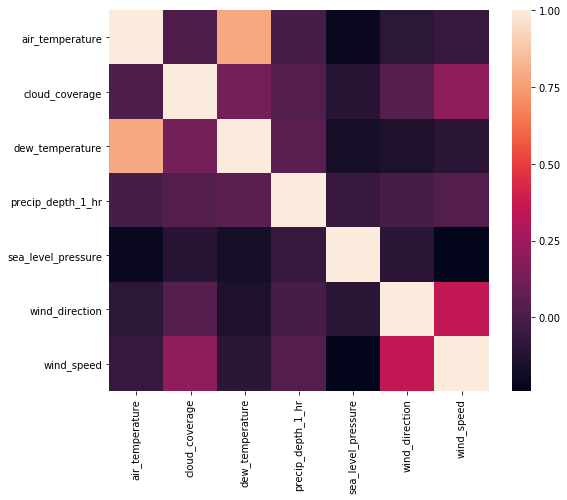

In [127]:
weather_cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed' ]
plt.figure(figsize=(8.5,7))
sns.heatmap(weather_train[weather_cols].corr())

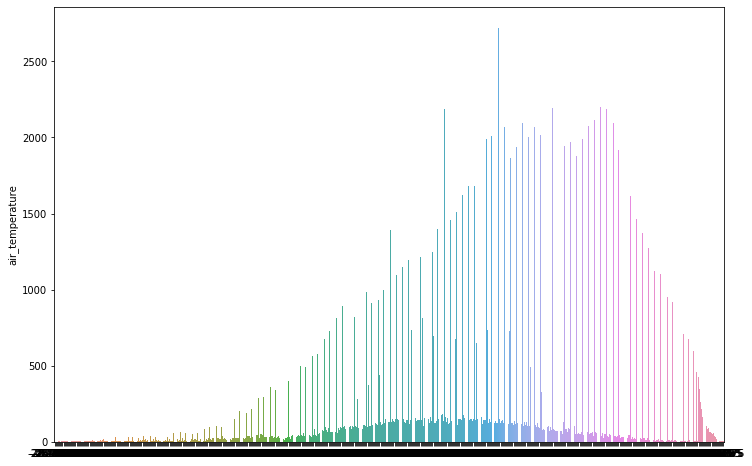

In [157]:
plt.figure(figsize = (12,8))
w1 = weather_train['air_temperature'].value_counts()
sns.barplot(w1.index,w1)

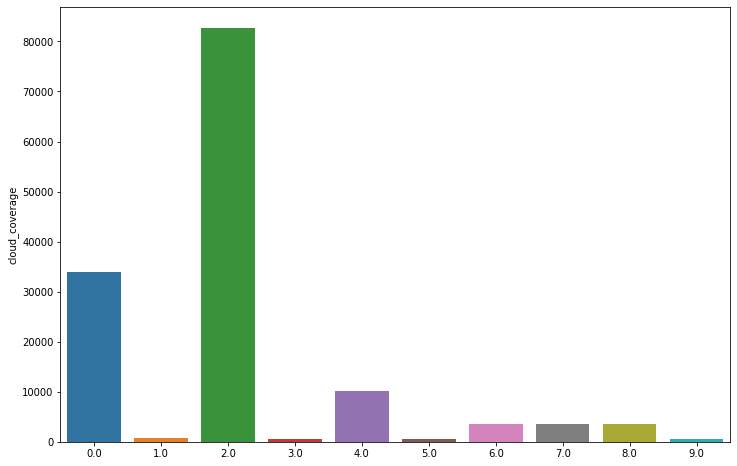

In [158]:
plt.figure(figsize = (12,8))
w2 = weather_train['cloud_coverage'].value_counts()
sns.barplot(w2.index,w2)

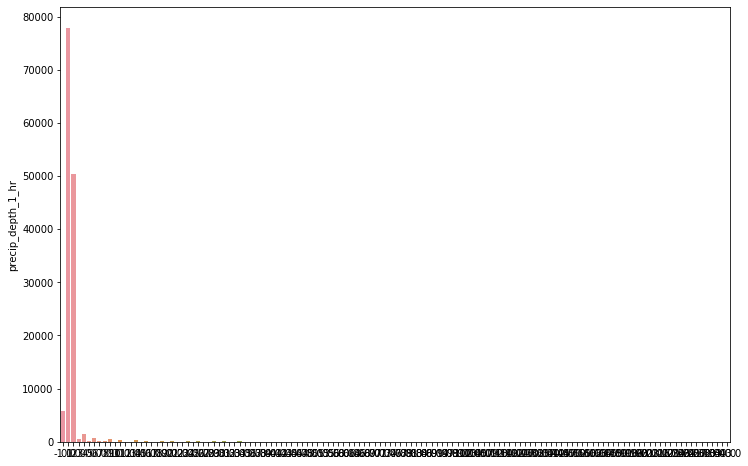

In [159]:
plt.figure(figsize = (12,8))
w3 = weather_train['precip_depth_1_hr'].value_counts()
sns.barplot(w3.index,w3)

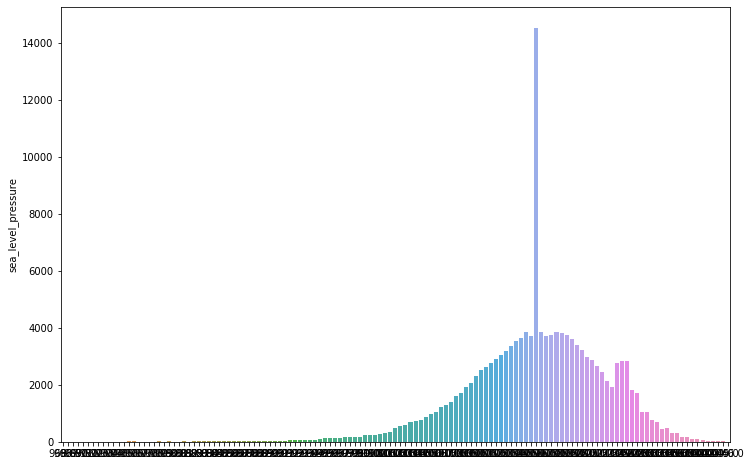

In [160]:
plt.figure(figsize = (12,8))
w4 = weather_train['sea_level_pressure'].value_counts()
sns.barplot(w4.index,w4)

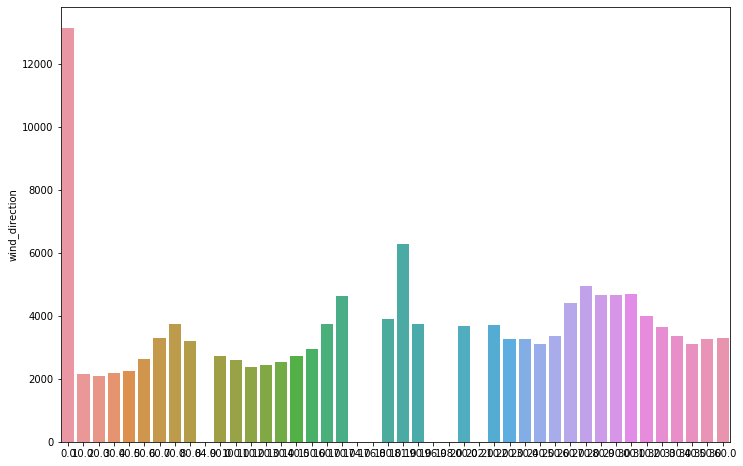

In [164]:
plt.figure(figsize = (12,8))
w5 = weather_train['wind_direction'].value_counts()
sns.barplot(w5.index,w5)

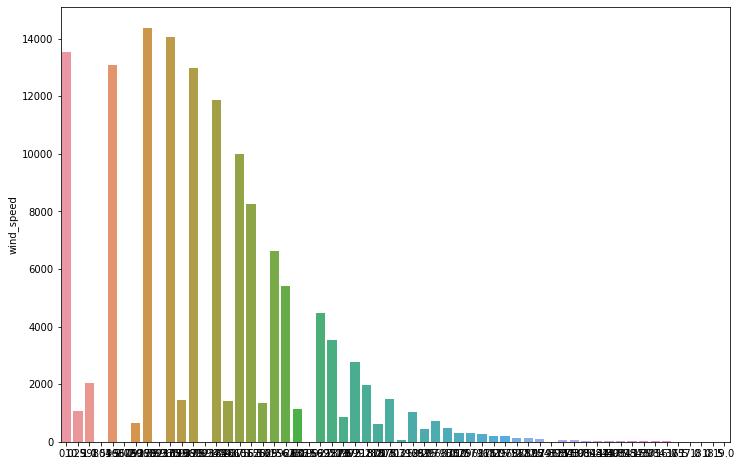

In [163]:
plt.figure(figsize = (12,8))
w5 = weather_train['wind_speed'].value_counts()
sns.barplot(w5.index,w5)

#### 4.2 correlation of buildings

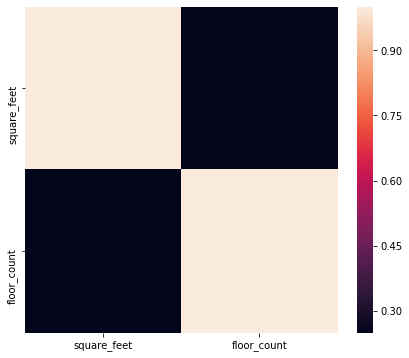

In [130]:
building_cols = ['square_feet','floor_count']
plt.figure(figsize=(7,6))
sns.heatmap(building_metadata[building_cols].corr())

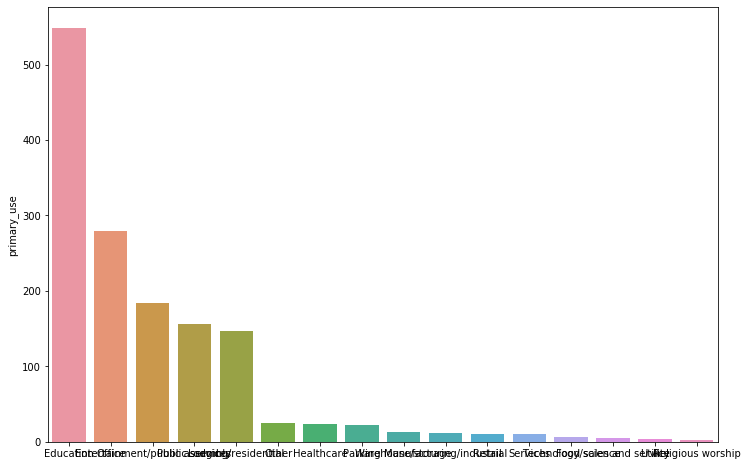

In [148]:
plt.figure(figsize = (12,8))
primuse = building_metadata['primary_use'].value_counts()
sns.barplot(primuse.index,primuse)

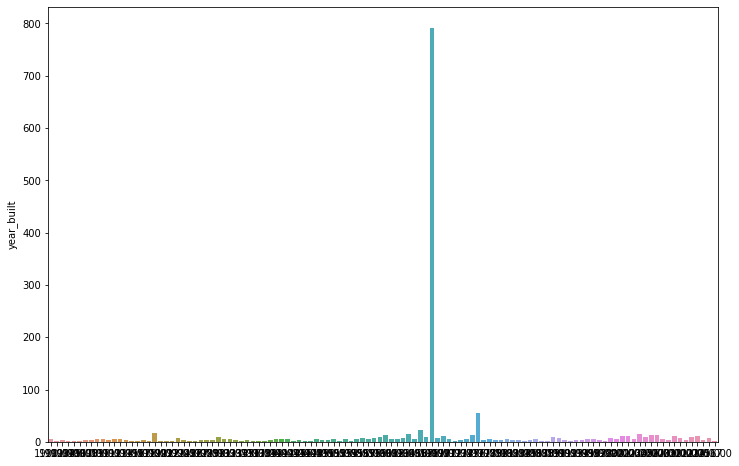

In [167]:
plt.figure(figsize = (12,8))
b2 = building_metadata['year_built'].value_counts()
sns.barplot(b2.index,b2)

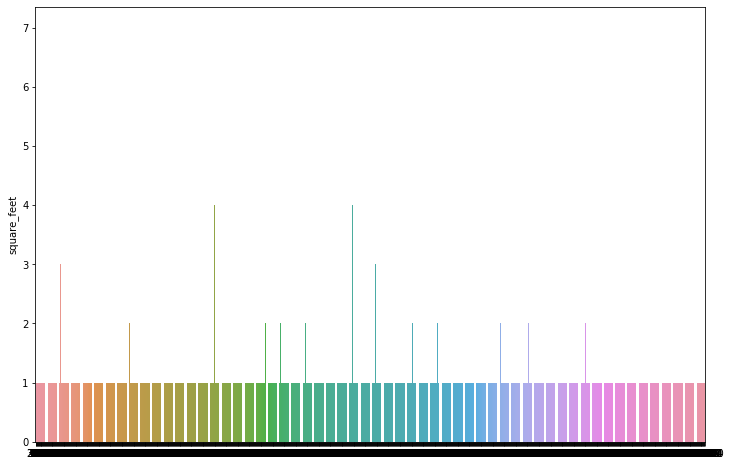

In [168]:
plt.figure(figsize = (12,8))
b3 = building_metadata['square_feet'].value_counts()
sns.barplot(b3.index,b3)

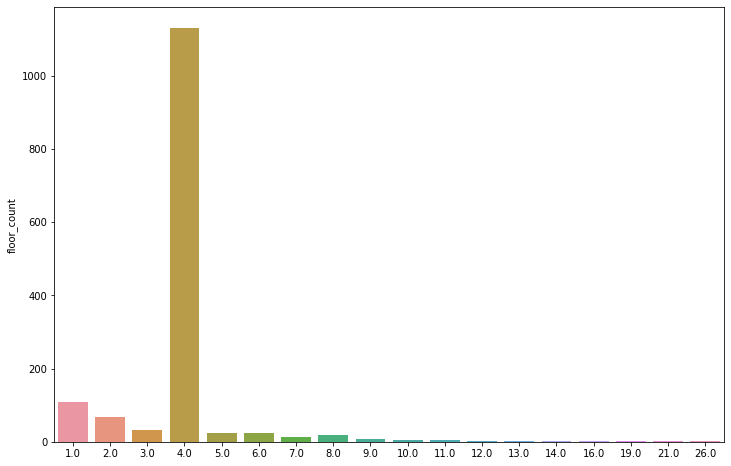

In [170]:
plt.figure(figsize = (12,8))
b4 = building_metadata['floor_count'].value_counts()
sns.barplot(b4.index,b4)

#### 4.3 K-means cluster on weather and buildings

In [ ]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot

X = weather_building
model = KMeans(n_clusters=4)
model.fit(X)
yhat = model.predict(X)
clusters = unique(yhat)

for cluster in clusters:
    row_ix = where(yhat == cluster)
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
pyplot.show()

### 5. SARIMA Model define and train

#### 5.1 electricity

In [172]:
electricity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11706016 entries, 103 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float32
dtypes: float32(1), int64(2), object(1)
memory usage: 401.9+ MB


In [174]:
electricity = electricity[['timestamp','meter_reading']]
electricity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11706016 entries, 103 to 20216099
Data columns (total 2 columns):
timestamp        object
meter_reading    float32
dtypes: float32(1), object(1)
memory usage: 223.3+ MB


In [198]:
emeans = electricity.groupby('timestamp')['meter_reading'].mean()
emeans.head()

timestamp
2016-01-01 00:00:00    113.992256
2016-01-01 01:00:00    129.595398
2016-01-01 02:00:00    129.628036
2016-01-01 03:00:00    129.767380
2016-01-01 04:00:00    130.099594
Name: meter_reading, dtype: float32

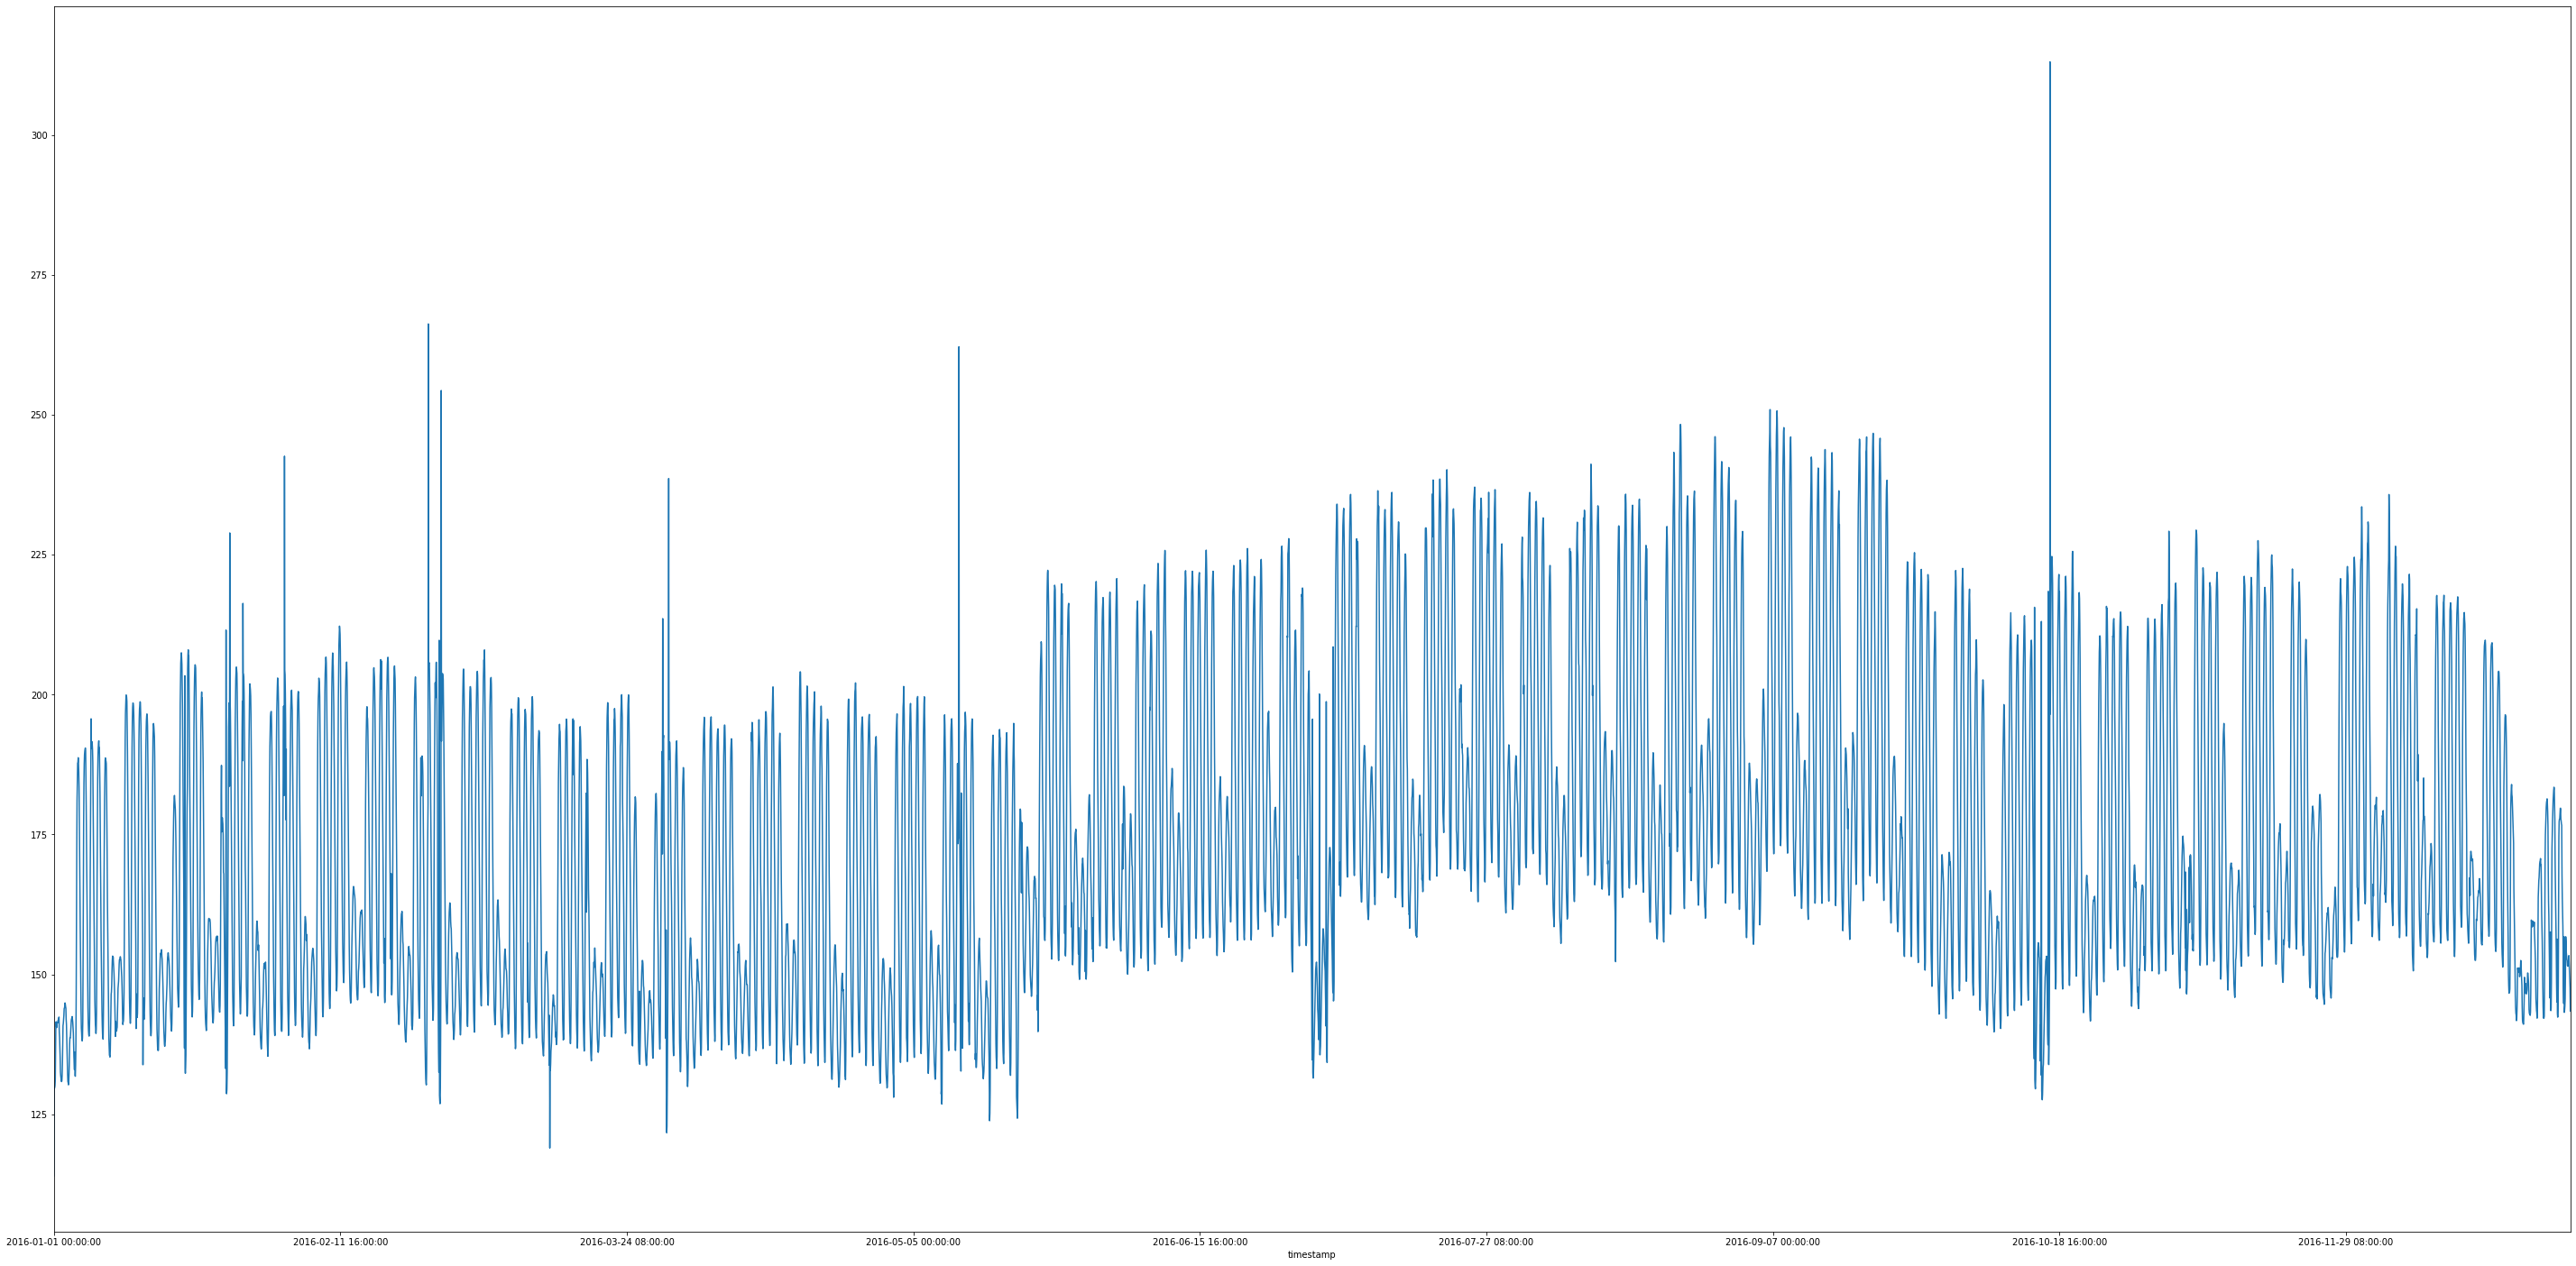

In [197]:
plt.figure(figsize=(50,25))
emeans.plot()
plt.show()

In [206]:
#find the least AIC
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
 
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
 
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
 
warnings.filterwarnings("ignore") # specify to ignore warning messages
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(emeans,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
 
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:115864.78071455465
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:108817.91999522553
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:89660.6090543117
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:80806.09554883055
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:89559.97225932528
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:80914.83554056296
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:73460.12639697493
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:73160.50802759727
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:104259.30033361299
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:97373.20685589741
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:80069.76617819273
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:72007.01580173436
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:79950.05856165971
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:72104.74496224085
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2071      0.002   -129.431      0.000      -0.210      -0.204
ar.S.L12      -0.9996      0.000  -3359.104      0.000      -1.000      -0.999
ma.S.L12       0.9744      0.001    703.814      0.000       0.972       0.977
sigma2        30.9633      0.065    477.763      0.000      30.836      31.090


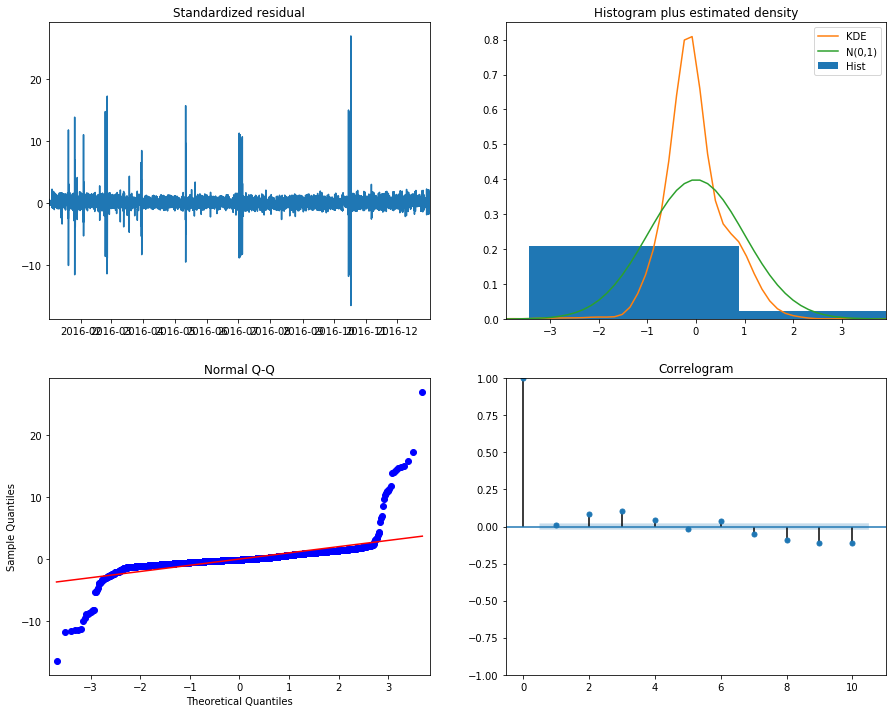

In [207]:
# Here we use ARIMA(1,1,0)(1,0,1)12
mod = sm.tsa.statespace.SARIMAX(emeans,
                                order=(1, 1, 0),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
 
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [248]:
# get_prediction on train and test
pred = results.get_prediction(start=pd.to_datetime('2016-10-01 00:00:00'), dynamic=False)
pred_ci = pred.conf_int() # return the confidence interval of fitted parameters
 
# plot real values and predicted values
#ax = emeans['2016-01-01 00:00:00':].plot(label='observed', figsize=(12,6)) 
#pred.predicted_mean.plot(ax = ax, label='Forecast', alpha=0.7)

# fill_between(x,y,z) fills the area between two horizontal curves defined by (x,y)
# and (x,z). And alpha refers to the alpha transparencies 
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
#plt.legend()
#plt.show()
 
# Evaluation of model
e_forecasted = pred.predicted_mean
e_truth = emeans['2016-10-01 00:00:00':]
 
# Compute the mean square error
rmse = (((e_forecasted - e_truth) ** 2).mean())**0.5
mape=np.mean(np.abs((e_forecasted - e_truth) / e_truth)) * 100
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
print('The MAPE of our forecasts is {}'.format(round(mape, 2)))

The Mean Squared Error of our forecasts is 6.5
The MAPE of our forecasts is 1.75


#### 5.2 chilledwater

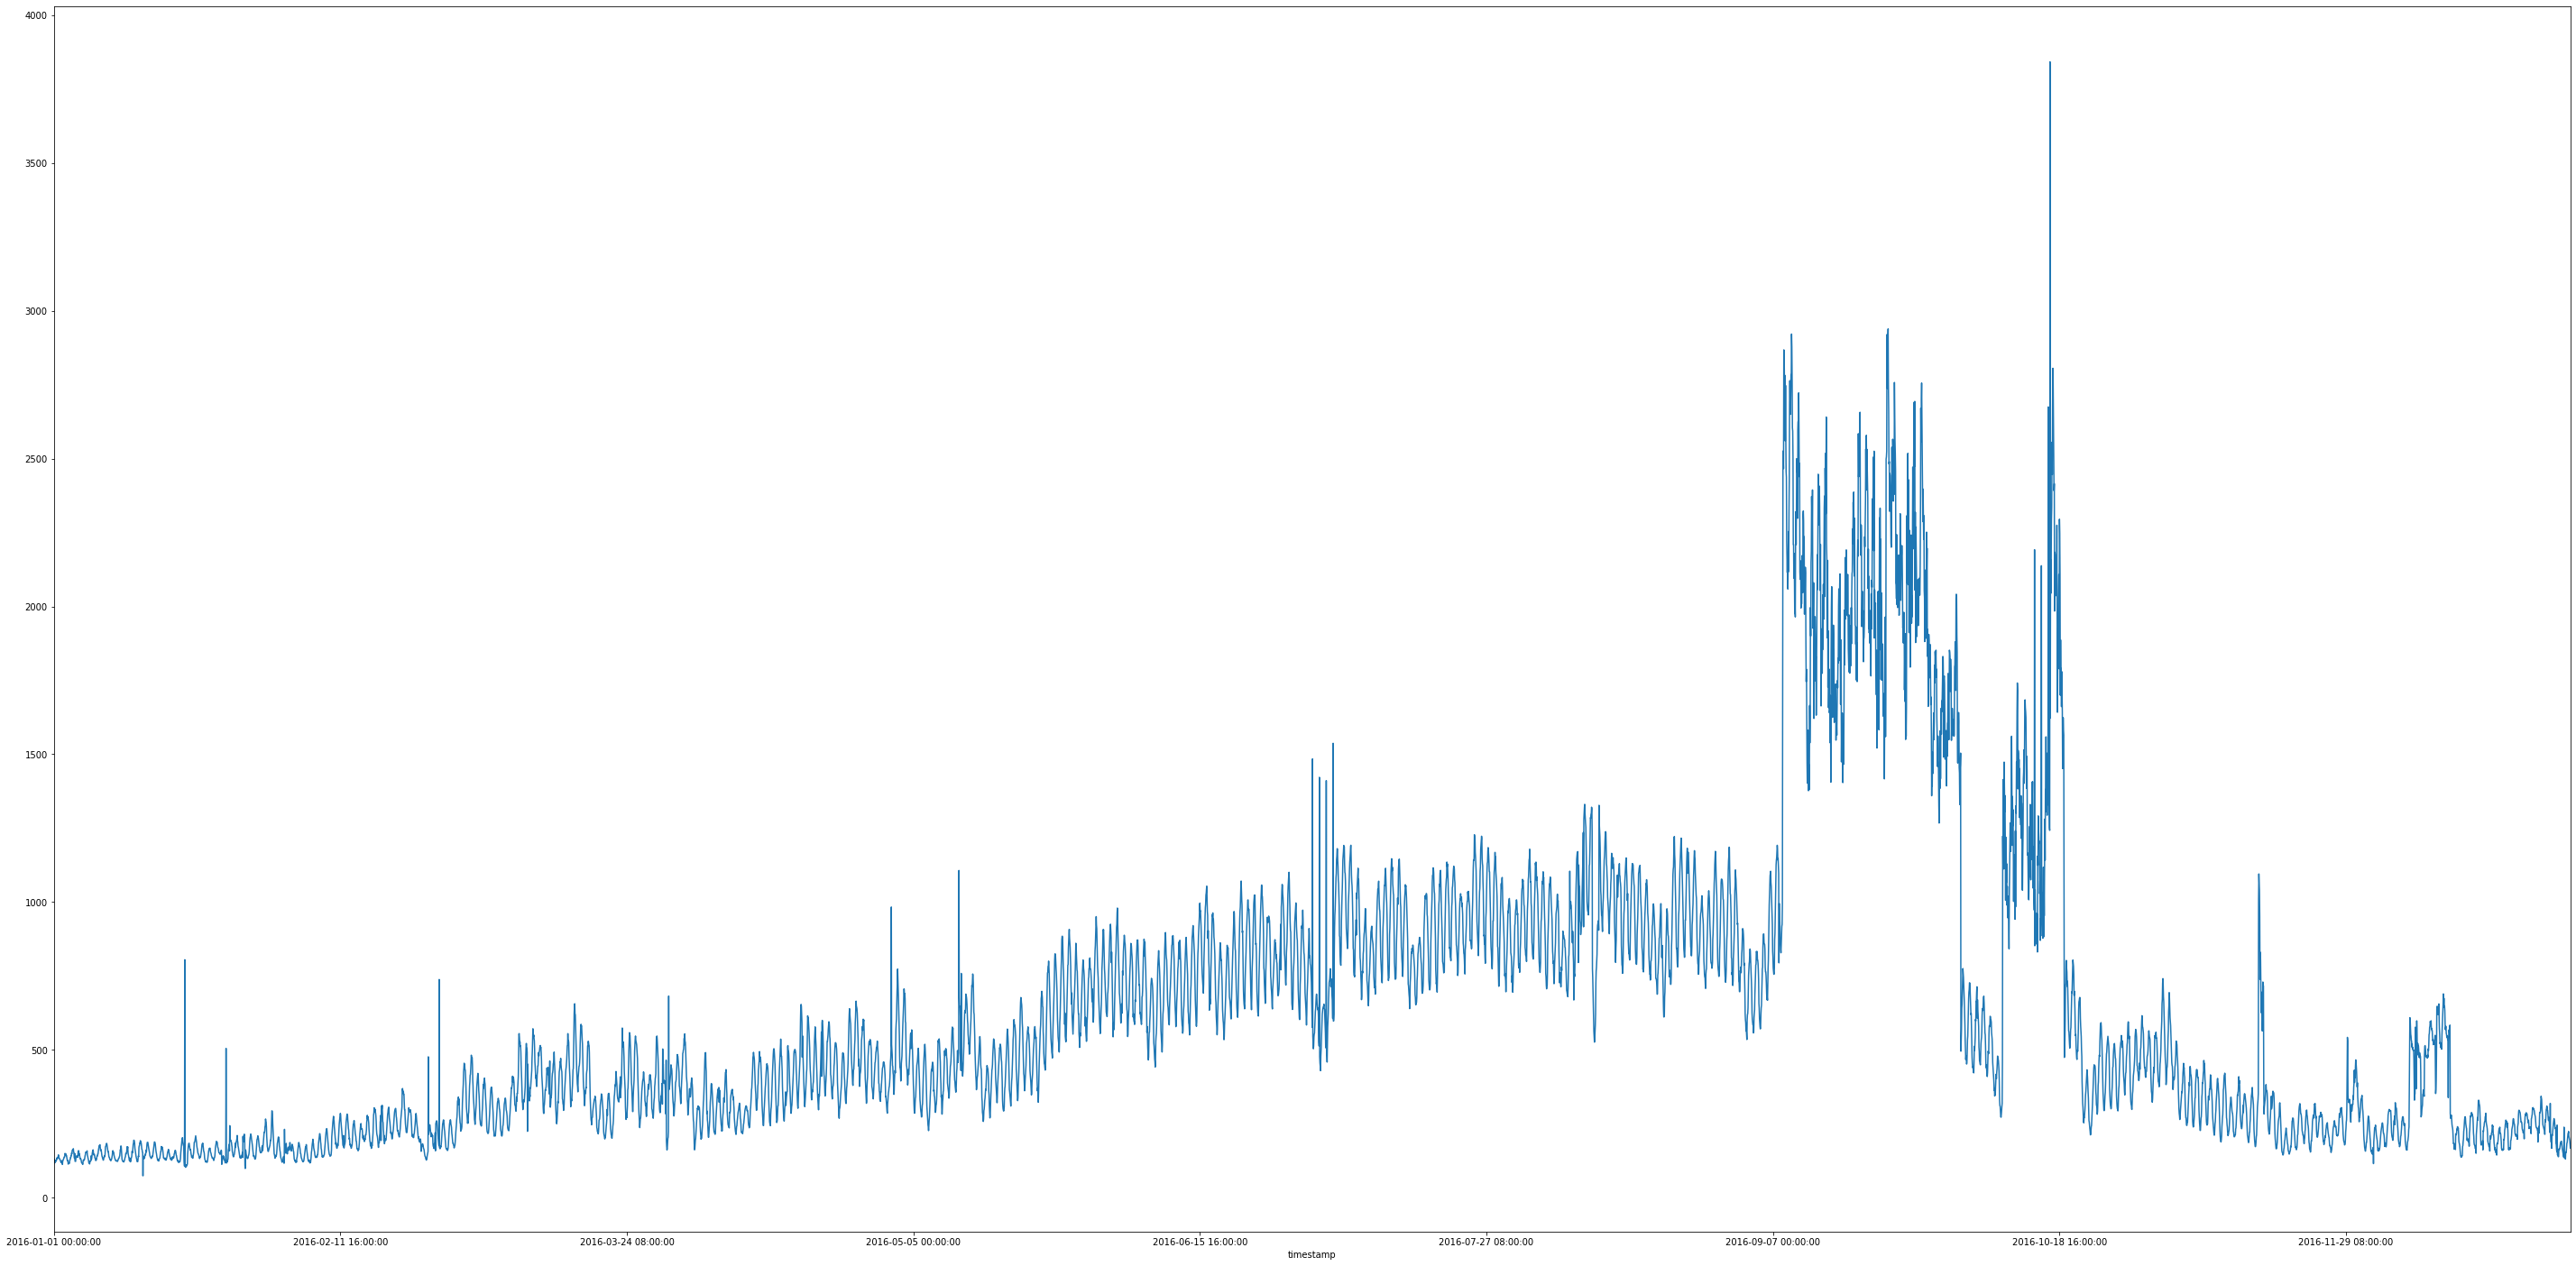

In [199]:
chilledwater = chilledwater[['timestamp','meter_reading']]
chwmeans = chilledwater.groupby('timestamp')['meter_reading'].mean()
plt.figure(figsize=(50,25))
chwmeans.plot()
plt.show()

In [255]:
#find the least AIC
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
 
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
 
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
 
warnings.filterwarnings("ignore") # specify to ignore warning messages
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(chwmeans,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
 
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:142488.40889720232
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:135818.2376261758
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:120219.79863354389
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:117000.2053099441
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:120056.11921084924
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:117121.87659461757
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:114757.8516587598
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:112320.70100021592
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:132020.76379486625
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:126498.18292554206
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:114796.46038235375
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:111216.70260963566
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:114571.50268262032
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:111330.54327339765
ARIMA(0, 0, 1)x(1, 1, 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0514      0.008     -6.321      0.000      -0.067      -0.035
ma.L1         -0.4430      0.008    -55.171      0.000      -0.459      -0.427
ar.S.L12      -0.9961      0.001  -1357.614      0.000      -0.998      -0.995
ma.S.L12       0.9469      0.002    583.277      0.000       0.944       0.950
sigma2      5546.1976      9.136    607.077      0.000    5528.292    5564.104


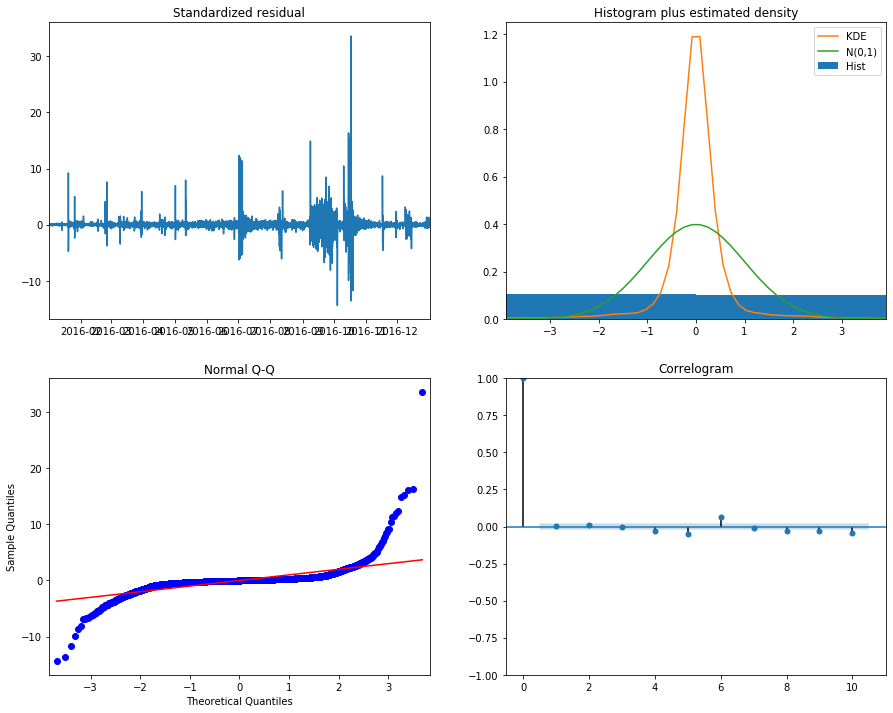

In [256]:
# Here we use ARIMA(1,1,1)(1,0,1)12
mod = sm.tsa.statespace.SARIMAX(chwmeans,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
 
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [257]:
# get_prediction on train and test
pred = results.get_prediction(start=pd.to_datetime('2016-10-01 00:00:00'), dynamic=False)
pred_ci = pred.conf_int() # return the confidence interval of fitted parameters
#plt.show()
 
# Evaluation of model
chw_forecasted = pred.predicted_mean
chw_truth = chwmeans['2016-10-01 00:00:00':]
 
# Compute the mean square error
rmse = (((chw_forecasted - chw_truth) ** 2).mean())**0.5
mape=np.mean(np.abs((chw_forecasted - chw_truth) / chw_truth)) * 100
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
print('The MAPE of our forecasts is {}'.format(round(mape, 2)))

The Mean Squared Error of our forecasts is 103.13
The MAPE of our forecasts is 6.56


#### 5.3 steam

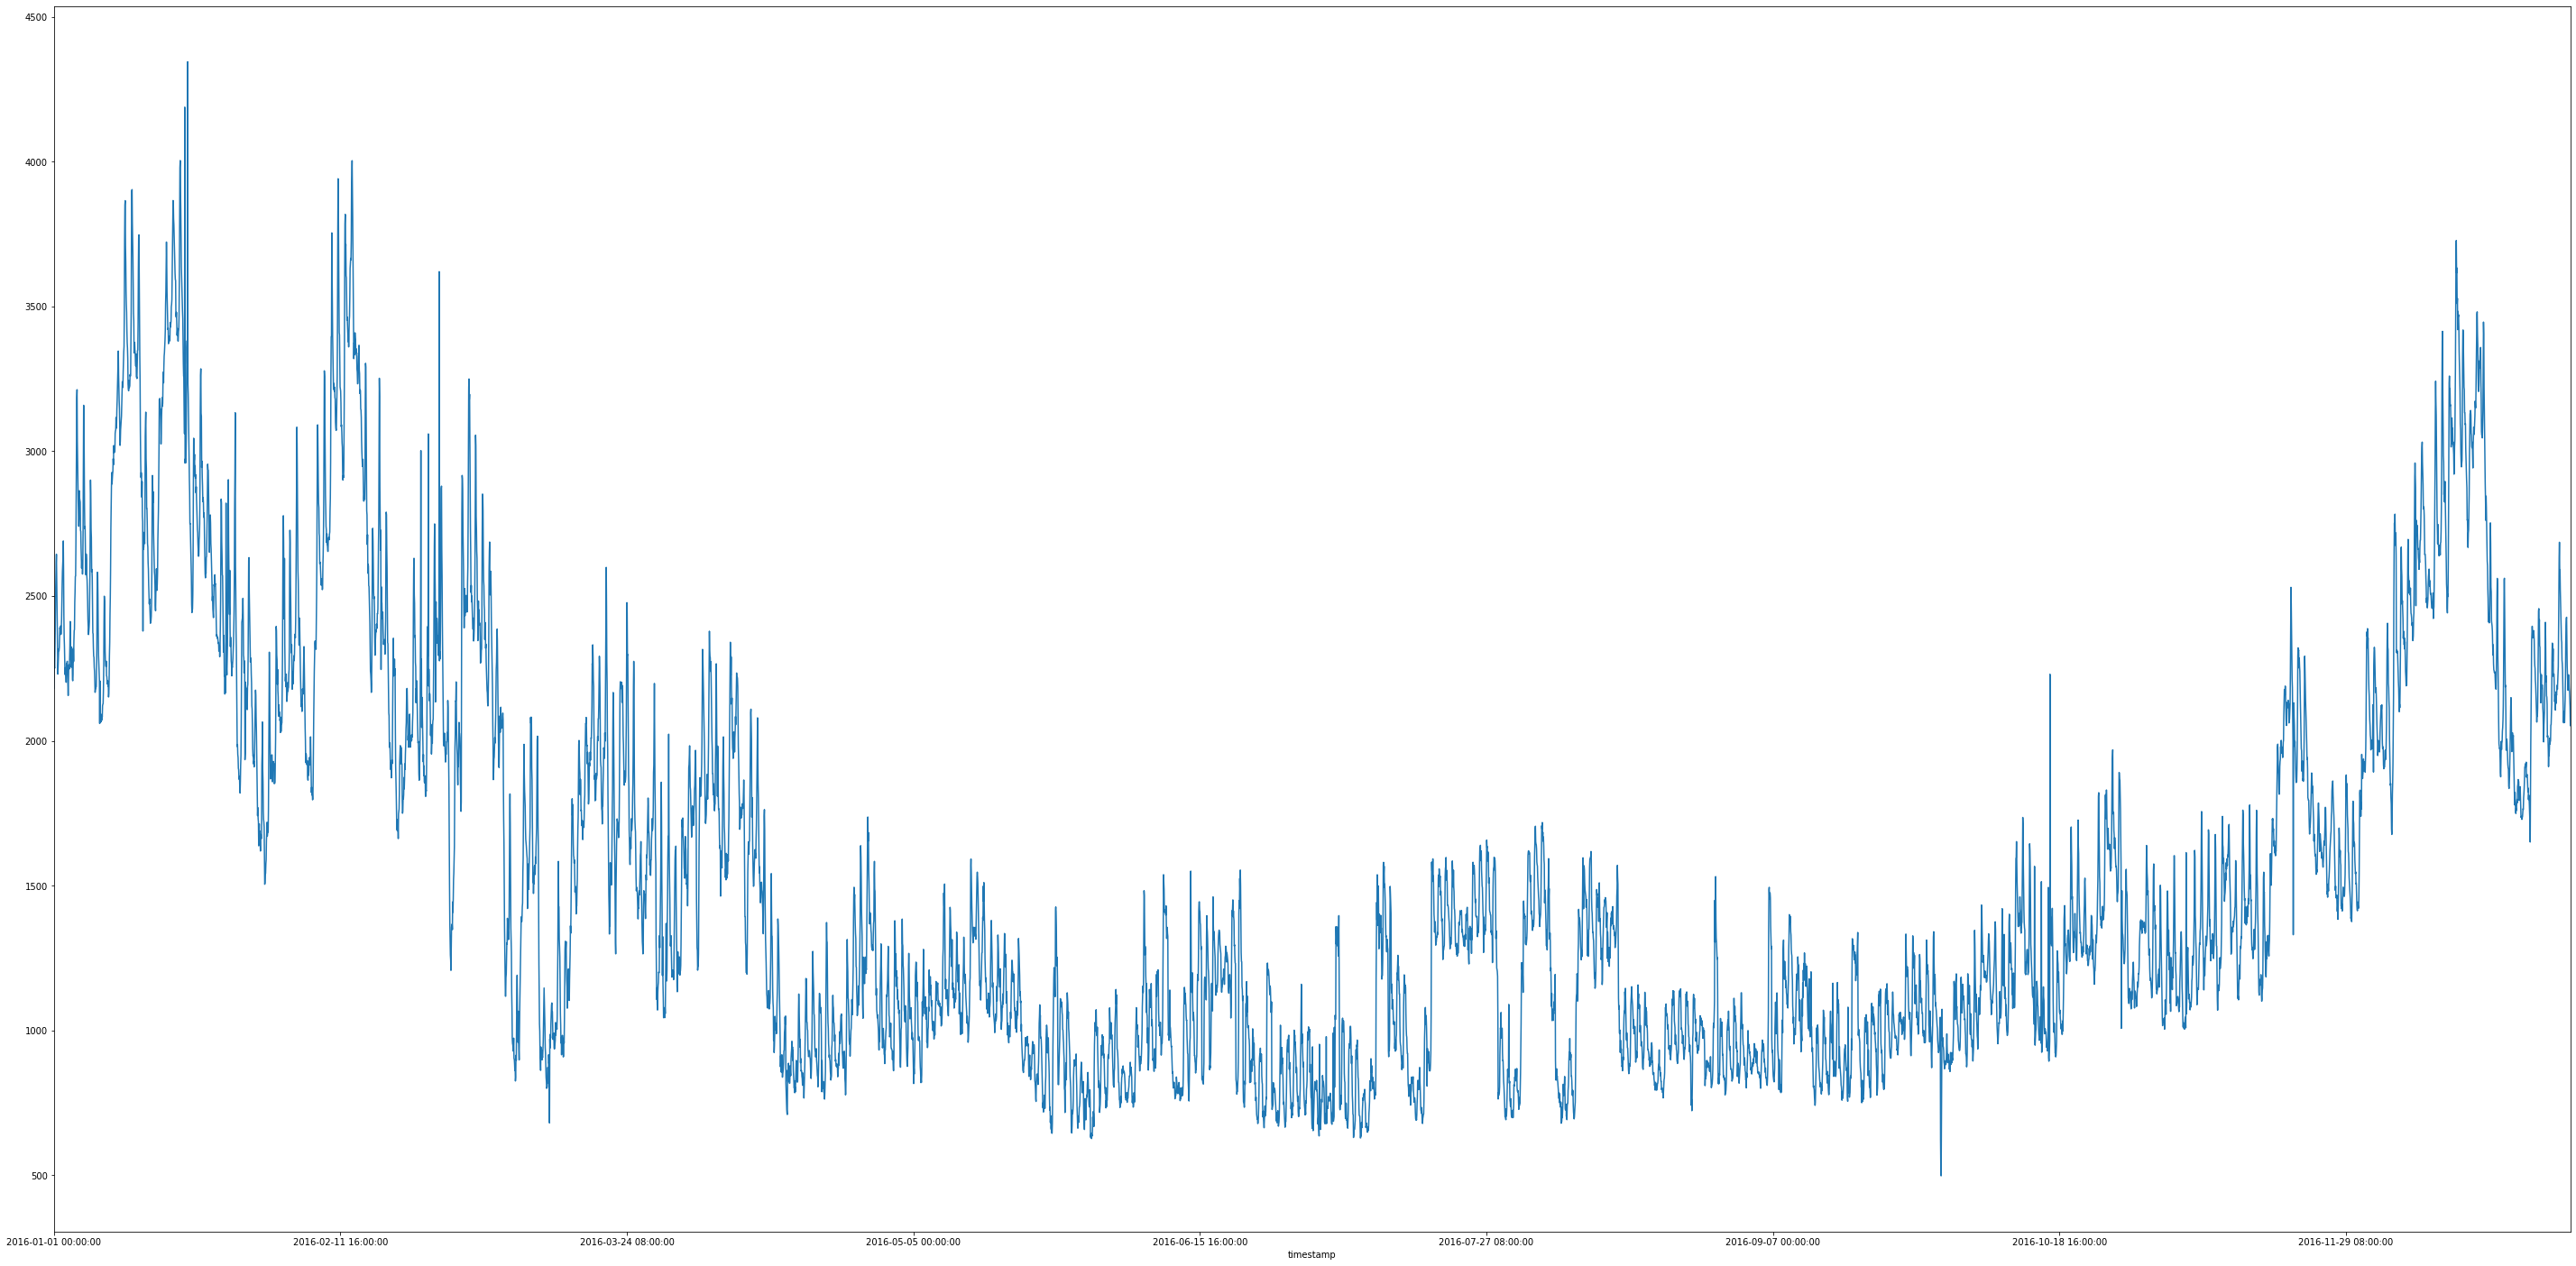

In [200]:
steam = steam[['timestamp','meter_reading']]
stmeans = steam.groupby('timestamp')['meter_reading'].mean()
plt.figure(figsize=(50,25))
stmeans.plot()
plt.show()

In [258]:
p = d = q = range(0, 2)
 
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
 
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
 
warnings.filterwarnings("ignore") # specify to ignore warning messages
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(stmeans,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
 
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:155469.36979976046
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:147121.67441478168
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:124086.62391057325
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:121269.55601202043
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:124036.84843581183
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:121752.58537735172
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:119283.39951253086
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:117127.43032447729
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:144032.07449883426
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:136009.2502360203
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:116356.23925891443
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:113326.7744868855
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:116298.50492307293
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:113461.23536755313
ARIMA(0, 0, 1)x(1, 1,

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9583      0.007   -145.324      0.000      -0.971      -0.945
ma.L1          0.9195      0.008    114.421      0.000       0.904       0.935
ar.S.L12      -0.2571      0.006    -40.842      0.000      -0.269      -0.245
ma.S.L12      -0.9726      0.003   -387.573      0.000      -0.977      -0.968
sigma2      5521.5591     20.321    271.715      0.000    5481.730    5561.388


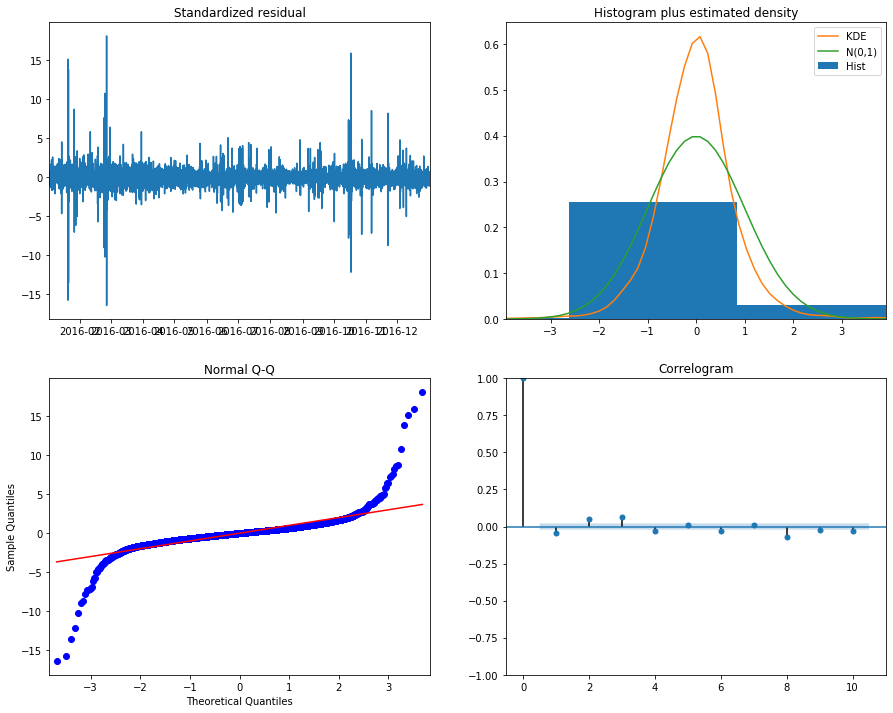

In [259]:
# Here we use ARIMA(1,1,1)(1,1,1)12
mod = sm.tsa.statespace.SARIMAX(stmeans,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
 
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [260]:
# get_prediction on train and test
pred = results.get_prediction(start=pd.to_datetime('2016-10-01 00:00:00'), dynamic=False)
pred_ci = pred.conf_int() # return the confidence interval of fitted parameters
#plt.show()
 
# Evaluation of model
st_forecasted = pred.predicted_mean
st_truth = stmeans['2016-10-01 00:00:00':]
 
# Compute the mean square error
rmse = (((st_forecasted - st_truth) ** 2).mean())**0.5
mape=np.mean(np.abs((st_forecasted - st_truth) / st_truth)) * 100
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
print('The MAPE of our forecasts is {}'.format(round(mape, 2)))

The Mean Squared Error of our forecasts is 74.75
The MAPE of our forecasts is 2.86


#### 5.4 hotwater

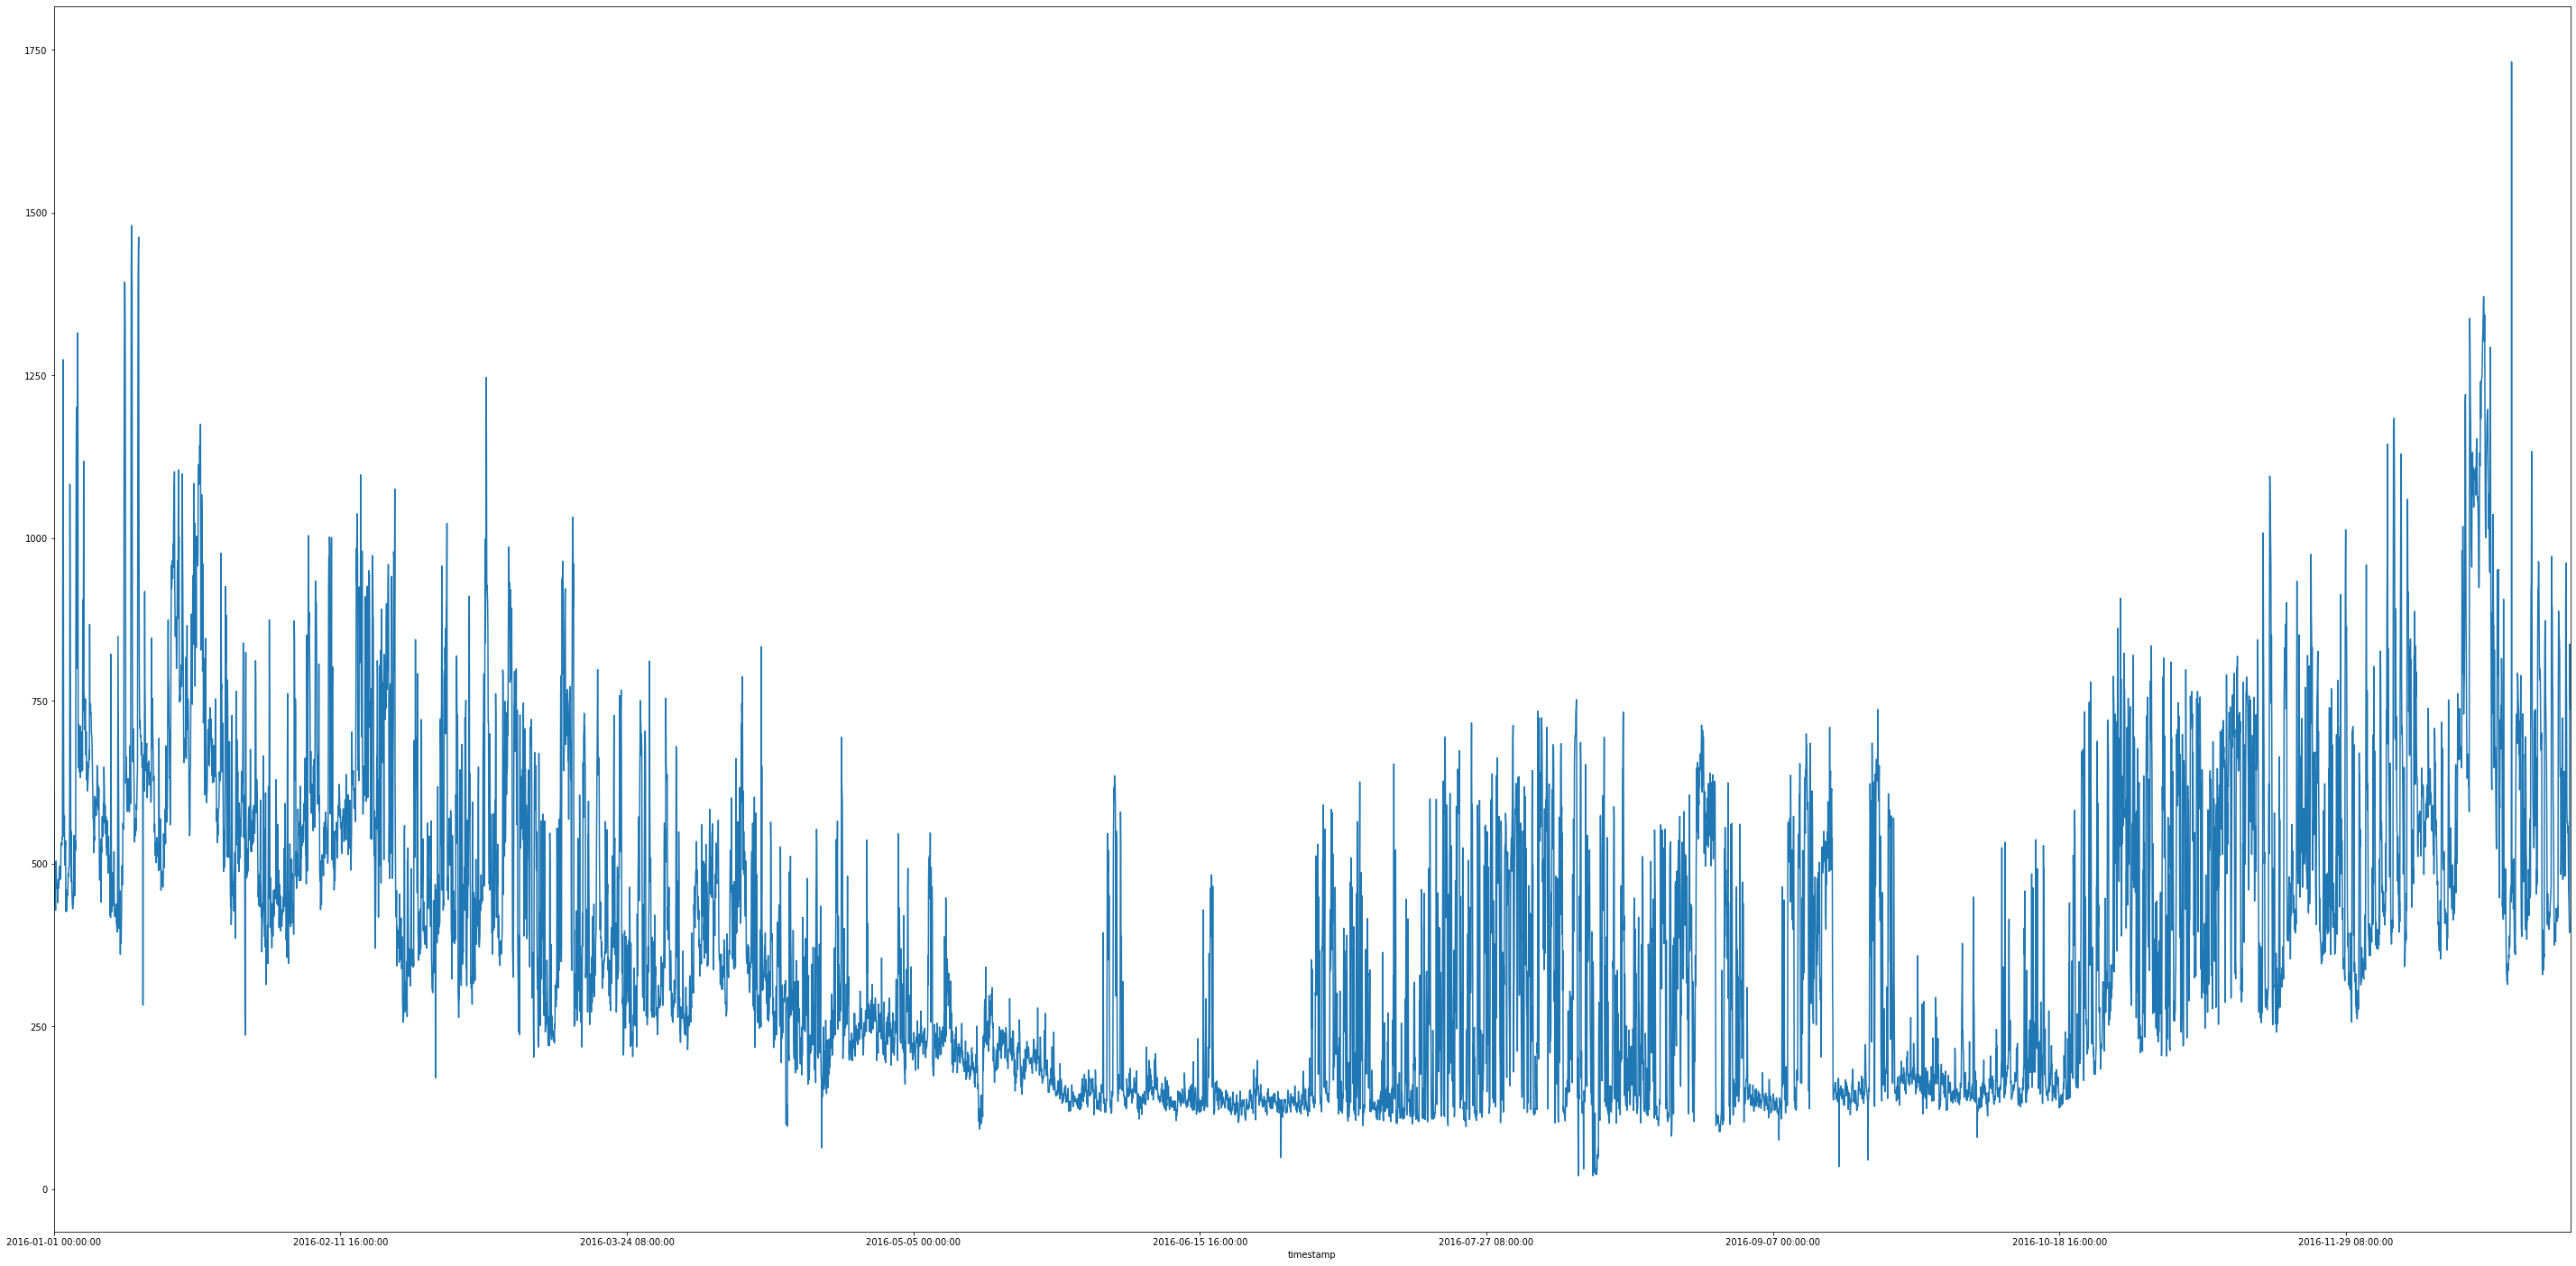

In [201]:
hotwater = hotwater[['timestamp','meter_reading']]
hwmeans = hotwater.groupby('timestamp')['meter_reading'].mean()
plt.figure(figsize=(50,25))
hwmeans.plot()
plt.show()

In [261]:
p = d = q = range(0, 2)
 
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
 
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
 
warnings.filterwarnings("ignore") # specify to ignore warning messages
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(hwmeans,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
 
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:132320.75893516606
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:126641.76812947594
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:117860.02176922443
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:113796.94641876809
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:117436.69650726994
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:113930.11459330536
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:114555.65418431303
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:113798.93611939294
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:122928.52776979144
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:118745.30032943275
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:113319.15256917852
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:108827.83199258117
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:112691.33872091165
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:108960.17246139795
ARIMA(0, 0, 1)x(1, 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7212      0.006    125.643      0.000       0.710       0.732
ma.L1         -0.9577      0.003   -304.951      0.000      -0.964      -0.952
ar.S.L12      -0.0276      0.010     -2.807      0.005      -0.047      -0.008
ma.S.L12      -1.0164      0.002   -515.598      0.000      -1.020      -1.013
sigma2      9001.9206     74.670    120.556      0.000    8855.570    9148.271


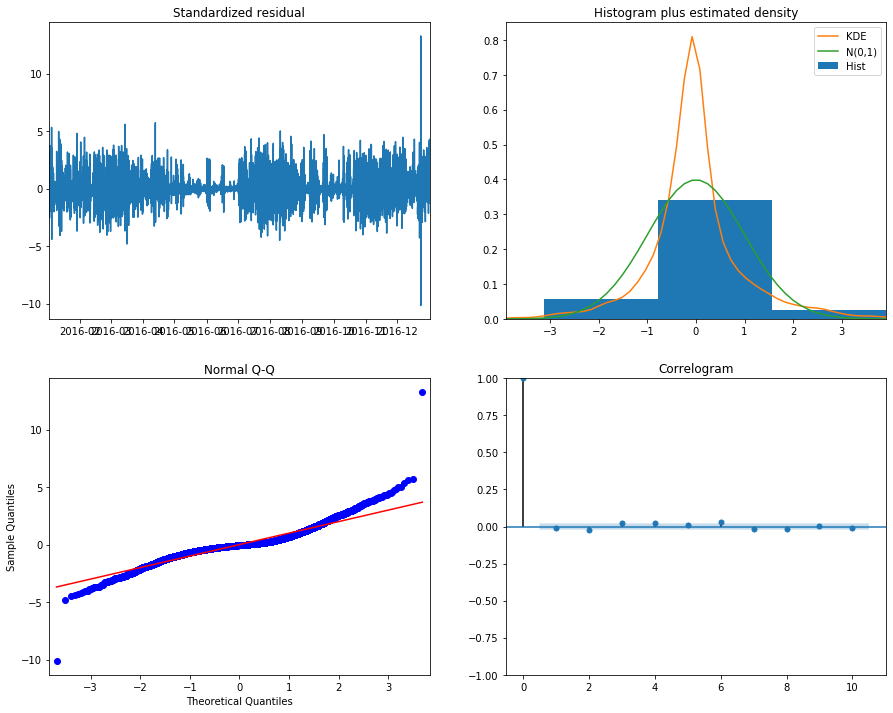

In [262]:
# Here we use ARIMA(1,1,1)(1,1,1)12
mod = sm.tsa.statespace.SARIMAX(hwmeans,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
 
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [263]:
# get_prediction on train and test
pred = results.get_prediction(start=pd.to_datetime('2016-10-01 00:00:00'), dynamic=False)
pred_ci = pred.conf_int() # return the confidence interval of fitted parameters
#plt.show()
 
# Evaluation of model
hw_forecasted = pred.predicted_mean
hw_truth = hwmeans['2016-10-01 00:00:00':]
 
# Compute the mean square error
rmse = (((hw_forecasted - hw_truth) ** 2).mean())**0.5
mape=np.mean(np.abs((hw_forecasted - hw_truth) / hw_truth)) * 100
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
print('The MAPE of our forecasts is {}'.format(round(mape, 2)))

The Mean Squared Error of our forecasts is 110.68
The MAPE of our forecasts is 16.76
